In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

rest_p_t = torch.from_numpy(rest_p).float()
nback_p_t = torch.from_numpy(nback_p).float()
emoid_p_t = torch.from_numpy(emoid_p).float()

print('Complete')

Complete


In [7]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [55]:
import torch.nn as nn
import torch.nn.functional as F

nRoi = rest_p_t.shape[1]
nLayer = 3
# nHid = 20
nFeat = X_all.shape[1]
nHidFeat = 30
nEdge = 3
order = 5

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = torch.cat([p, p**2, p**3, p**4, p**5])
        pps.append(pp)
    return torch.stack(pps)

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

def threshEdges(edges):
    k = 40
    n = edges.shape[0]
    vals, idcs = torch.sort(edges.flatten())
    edges[edges < vals[-k*n]] = 0.001
    return edges

# Cosine similarity
def calcEdges(ps1, ps2, mask1, mask2):
    mps1 = torch.einsum('aij,ij->aij',ps1,mask1)
    mps2 = torch.einsum('aij,ij->aij',ps2,mask2)
    e = torch.einsum('aij,bij->ab',mps1,mps2)
    Fps1 = torch.einsum('aij,aij->a',mps1,mps1)**0.5
    Fps2 = torch.einsum('aij,aij->a',mps2,mps2)**0.5
    e /= Fps1.unsqueeze(1)
    e /= Fps2.unsqueeze(1).T
    return normalize(e)

# def attn(atlayers, ps, feat, idx):
#     x = torch.cat([ps,feat[idx]])
#     for layer in atlayers:
#         x = layer(x)
#     return x

def gcn(layers, edges, feat, idx, bn):
#     x = attn(atlayers, ps, feat, idx).unsqueeze(0).unsqueeze(1)
#     edges = x*edges
    
    h = [None]*(nLayer+1)
#     s = torch.einsum('abc->ac',edges).unsqueeze(1)
    h[0] = feat
    
    for i in range(1,nLayer+1):
        h[i] = torch.einsum('abc,bf->afc',edges,h[i-1])
#         h[i] /= s
        h[i] = h[i].reshape(feat.shape[0],-1)
        h[i] = F.relu(layers[i-1](h[i]))
    
    return torch.cat(h[1:], dim=1)

class MaskGcn(nn.Module):
    def __init__(self):
        super(MaskGcn, self).__init__()
        
        # Masks
#         self.maskR = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
        self.maskN = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
        self.maskE = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
#         self.maskRN = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
#         self.maskRE = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
        self.maskNE = nn.Parameter(torch.ones(nRoi,nRoi).cuda())
        
        # Attention
#         self.atl1 = nn.Linear(nRoi*nRoi+nFeat,nMask*5).cuda()
#         self.atl2 = nn.Linear(nMask*5,nMask).cuda()
#         self.at = [self.atl1, self.atl2]
        
        # MLP
#         self.fc1 = nn.Linear(nRoi*nRoi*order+nHidFeat*nLayer,nHid).cuda()
#         self.fc2 = nn.Linear(nHid,1).cuda()
        self.fc1 = nn.Linear(nRoi*nRoi*order+nHidFeat*nLayer,1).cuda()
        
        # GCN
        self.l1 = nn.Linear(nFeat*nEdge,nHidFeat).cuda()
        self.l2 = nn.Linear(nHidFeat*nEdge,nHidFeat).cuda()
        self.l3 = nn.Linear(nHidFeat*nEdge,nHidFeat).cuda()
        self.ls = [self.l1,self.l2,self.l3]
        
        # Batch norm 1d
        self.bn = nn.BatchNorm1d(nHidFeat).cuda()
        
    def forward(self, x):
        trainNotTest = x[0]
        
#         maskR = torch.sigmoid(self.maskR)
        maskN = torch.sigmoid(self.maskN)
        maskE = torch.sigmoid(self.maskE)
#         maskRN = torch.sigmoid(self.maskRN)
#         maskRE = torch.sigmoid(self.maskRE)
        maskNE = torch.sigmoid(self.maskNE)
        
        if trainNotTest:
            idcs = x[1]
            
            # Edges
#             e1 = calcEdges(self.psRest,self.psRest,maskR,maskR)
#             e2 = calcEdges(self.psRest,self.psNback,maskRN,maskRN)
            e3 = calcEdges(self.psNback,self.psNback,maskN,maskN)
            e4 = calcEdges(self.psEmoid,self.psEmoid,maskE,maskE)
#             e5 = calcEdges(self.psRest,self.psEmoid,maskRE,maskRE)
            e6 = calcEdges(self.psNback,self.psEmoid,maskNE,maskNE)
            e = torch.stack([e3,e4,e6],dim=2)
            
            # Pearsons
            x = []
            
            # Feat
            h = []
            
            for i in idcs:
                x.append(self.psRest[i].flatten())
                feat = self.feat.detach().clone()
                feat[i,0] = 0
                h.append(gcn(self.ls, e, feat, i, self.bn)[i])
            
            x = torch.stack(x)
            h = torch.stack(h)
        else:
            apsRest = x[1][0]
            apsNback = x[1][1]
            apsEmoid = x[1][2]
            oFeat = x[2].detach().clone()
            
#             assert len(apsRest) == len(apsNback)
            
            # Pearsons
#             x = makePoly(aps.reshape(aps.shape[0],-1))
            x = apsRest.reshape(apsRest.shape[0], -1)
#             x = apsNback.reshape(apsNback.shape[0], -1)
#             x = apsEmoid.reshape(apsEmoid.shape[0], -1)
            
            # Feat
            h = []
                
            for i in range(len(apsRest)):
#                 psRest = torch.cat([apsRest[i].unsqueeze(0), self.psRest])
                psNback = torch.cat([apsNback[i].unsqueeze(0), self.psNback])
                psEmoid = torch.cat([apsEmoid[i].unsqueeze(0), self.psEmoid])

                # Calc edges
#                 e1 = calcEdges(psRest,psRest,maskR,maskR)
#                 e2 = calcEdges(psRest,psNback,maskRN,maskRN)
                e3 = calcEdges(psNback,psNback,maskN,maskN)
                e4 = calcEdges(psEmoid,psEmoid,maskE,maskE)
#                 e5 = calcEdges(psRest,psEmoid,maskRE,maskRE)
                e6 = calcEdges(psNback,psEmoid,maskNE,maskNE)
                e = torch.stack([e3,e4,e6],dim=2)
                
                # Feat
                feat = torch.cat([oFeat[i:i+1], self.feat])
                feat[0,0] = 0   
                h.append(gcn(self.ls, e, feat, 0, self.bn)[0])
            
            h = torch.stack(h)
        
        x = torch.cat([makePoly(x), h], dim=1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        x = self.fc1(x)
    
        return x

import random

# gcnMasks = []
# weights = []
agesPredGCN = np.zeros(X_all.shape[0])

# Loop over splits 
splitIdx = 0
for trainIdcs, testIdcs in groups:

    maskgcn = MaskGcn()
    optim = torch.optim.Adam(maskgcn.parameters(), lr=1e-3)

    train_rest_p_t = rest_p_t[trainIdcs].cuda()
    test_rest_p_t = rest_p_t[testIdcs]
    
    train_nback_p_t = nback_p_t[trainIdcs].cuda()
    test_nback_p_t = nback_p_t[testIdcs]
    
    train_emoid_p_t = emoid_p_t[trainIdcs].cuda()
    test_emoid_p_t = emoid_p_t[testIdcs]

    X_train = X_all[trainIdcs]
    X_train_t = torch.from_numpy(X_train).float().cuda()
    
    X_test = X_all[testIdcs]
    X_test_t = torch.from_numpy(X_test).float().cuda()

    N = len(train_nback_p_t)
    running = 0
    nEpoch = 2000
    pPeriod = 50
    nB = 20
    wd = 20
    thresh = 0.5

    maskgcn.psRest = train_rest_p_t
    maskgcn.psNback = train_nback_p_t
    maskgcn.psEmoid = train_emoid_p_t
    maskgcn.feat = X_train_t

    for epoch in range(nEpoch):
        batch = []
        truth = torch.zeros(nB).cuda()
        for i in range(nB):
            idx = random.randint(0,N-1)
            batch.append(idx)
            truth[i] = X_train_t[idx, 0]
        optim.zero_grad()
        pred = maskgcn([True, batch]) 
        l0 = torch.sum((truth-pred.flatten())**2)
        l1 = torch.tensor(0).float().cuda()
        for param in [maskgcn.fc1.weight[0,0:5*nRoi*nRoi]]:
            l1 += wd*torch.sum(param**2)
        running += l0.detach().cpu() #+ l1.detach().cpu()
        loss = l0 + l1
        loss.backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpoch-1:
            if epoch != 0:
                if epoch % pPeriod != 0:
                    running /= epoch % pPeriod
                else:
                    running /= pPeriod
            print('epoch {:d} loss={:f}'.format(epoch, (running/nB)**0.5/12))
            if (running/nB)**0.5/12 < thresh:
                break
            running = 0
            
    print('Finished training')

#     gcnMasks.append([torch.sigmoid(maskgcn.maskRest).detach().cpu().numpy(), 
#                      torch.sigmoid(maskgcn.maskNback).detach().cpu().numpy(),
#                      torch.sigmoid(maskgcn.maskRNRest).detach().cpu().numpy(),
#                      torch.sigmoid(maskgcn.maskRNNback).detach().cpu().numpy()])
    
    nChunk = 1
    for i in range(int(X_test_t.shape[0]/nChunk)+1):
        st = i*nChunk
        end = st+nChunk
        if st >= X_test_t.shape[0]:
            break
        if end > X_test_t.shape[0]:
            end = X_test_t.shape[0]
        agesPredGCN[testIdcs[st:end]] = maskgcn([False, [test_rest_p_t[st:end].cuda(),
                                                         test_nback_p_t[st:end].cuda(),
                                                         test_emoid_p_t[st:end].cuda()], 
                                                 X_test_t[st:end]]).detach().cpu().numpy().flatten()
    
    print('Completed split {:}'.format(splitIdx))
    splitIdx += 1

print('Complete')

epoch 0 loss=16.782194


KeyboardInterrupt: 


[[1.         0.62101612]
 [0.62101612 1.        ]]
2.5491263523996492
2.0507561081644523


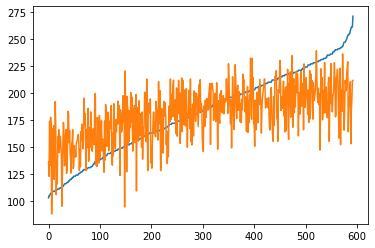

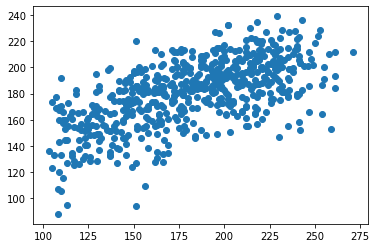

In [54]:
import matplotlib.pyplot as plt
import math

# y = X_train[:,0]
# idcs = torch.arange(0,len(y))
# yPred = maskgcn([True, idcs]).detach().numpy().flatten()

y = X_all[:,0]
yPred = agesPredGCN
print()    
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

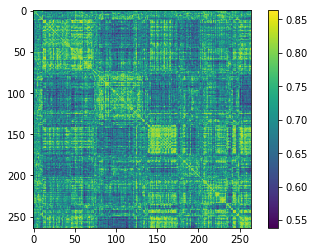

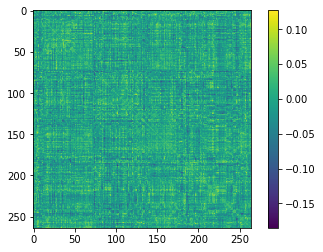

In [49]:
# stk = np.zeros([10,264,264])

# for i in range(10):
#     stk[i] = gcnMasks[i][3]
    
# mean = np.mean(stk, axis=0)
# std = np.std(stk, axis=0)

# plt.imshow(mean)
# plt.colorbar()
# plt.show()

# plt.imshow(std)
# plt.colorbar()
# plt.show()

maskR = torch.sigmoid(maskgcn.maskE).detach().cpu().numpy()

plt.imshow(maskR)
plt.colorbar()
plt.show()

w1 = maskgcn.fc1.weight[0,0*nRoi*nRoi:1*nRoi*nRoi].detach().cpu().numpy().reshape([nRoi,nRoi])

plt.imshow(w1)
plt.colorbar()
plt.show()

In [50]:
# Get standard deviations

rmse = np.zeros(10)
mae = np.zeros(10)
corr = np.zeros(10)

idx = 0
for trainIdcs, testIdcs in groups:
    y = X_all[testIdcs,0]
    yPred = agesPredGCN[testIdcs]
    
    corr[idx] = np.corrcoef(y, yPred)[0,1]
    rmse[idx] = (np.sum((y-yPred)**2)/len(y))**0.5/12
    mae[idx] = np.sum(np.abs(y-yPred))/12/len(y)
   
    idx += 1
    
print(np.mean(rmse))
print(np.std(rmse))
print(np.mean(mae))
print(np.std(mae))
print(np.mean(corr))
print(np.std(corr))

2.524867969491224
0.20509379795786425
2.0418964330669627
0.1580260249763963
0.6415105612330845
0.08570287058423189


In [51]:
# Save predictions

with open('../../Work/Abstract/PaperBin/PGI-GCN-Predictions-2-Rest-Emoid.bin', 'wb') as f:
    pickle.dump(agesPredGCN, f)
    
gcnMasks = [maskgcn.maskR, maskgcn.maskE, maskgcn.maskRE]
    
with open('../../Work/Abstract/PaperBin/PGI-GCN-Masks-2-Rest-Emoid.bin', 'wb') as f:
    pickle.dump(gcnMasks, f)
    
weights = maskgcn.fc1.weight.detach().cpu().numpy()

with open('../../Work/Abstract/PaperBin/PGI-GCN-Weights-2-Rest-Emoid.bin', 'wb') as f:
    pickle.dump(weights, f)
    
print('Complete')

Complete


In [52]:
# Check predictions

with open('../../Work/Abstract/PaperBin/PGI-GCN-Predictions-2-Rest-Emoid.bin', 'rb') as f:
    check = pickle.load(f)
    
rmse = np.zeros(10)
mae = np.zeros(10)
corr = np.zeros(10)

idx = 0
for trainIdcs, testIdcs in groups:
    y = X_all[testIdcs,0]
    yPred = check[testIdcs]
    
    corr[idx] = np.corrcoef(y, yPred)[0,1]
    rmse[idx] = (np.sum((y-yPred)**2)/len(y))**0.5/12
    mae[idx] = np.sum(np.abs(y-yPred))/12/len(y)
   
    idx += 1
    
print(np.mean(rmse))
print(np.std(rmse))
print(np.mean(mae))
print(np.std(mae))
print(np.mean(corr))
print(np.std(corr))

2.524867969491224
0.20509379795786425
2.0418964330669627
0.1580260249763963
0.6415105612330845
0.08570287058423189


In [9]:
maskgcn.psRest.requires_grad

AttributeError: 'MaskGcn' object has no attribute 'psRest'